# Measure variability of images in MedMNIST

This notebook demonstrates how to measure the variability of images in the MedMNIST dataset using Fréchet Inception Distance (FID), with ResNet18 as the feature extractor.

## Import Required Libraries

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision.transforms as T
import torchvision.models as models

from medmnist import ChestMNIST


## Load MedMNIST Dataset

We will load the ChestMNIST dataset from MedMNIST.

In [3]:
transform = T.Compose([
    T.ToTensor(),                 # convert H×W×C → tensor
    T.Normalize(mean=[0.5]*3, std=[0.5]*3)  # simple normalization
])

train_set = ChestMNIST(split="train", transform=transform, download=True, as_rgb=True)
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)


In [5]:
images, labels = next(iter(train_loader))

print("shape of images :", images.shape)
print("dtype :", images.dtype)
print("min pixel :", images.min().item())
print("max pixel :", images.max().item())


shape of images : torch.Size([64, 3, 28, 28])
dtype : torch.float32
min pixel : -1.0
max pixel : 0.9529411792755127


(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

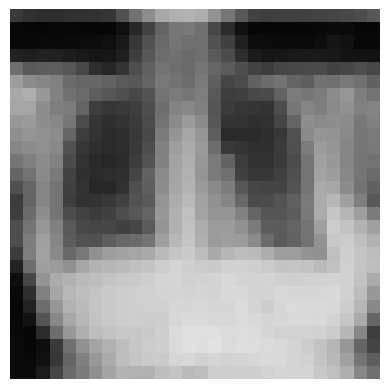

In [7]:
import matplotlib.pyplot as plt

# Take the first image of the batch
img = images[0]

# Normalize the image to [0,1] for display
img_vis = (img * 0.5) + 0.5
img_vis = img_vis.permute(1, 2, 0)  # C×H×W → H×W×C

plt.imshow(img_vis.numpy())
plt.axis("off")


## Build a pretrained ResNet18 feature extractor

In [8]:
import torch
from torch import nn
import torchvision.models as models

# 1. load a pretrained ResNet18 model on ImageNet
resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# 2. Set the model to evaluation mode
resnet.eval()

# 3. Remove the last classification layer (fc)
feature_extractor = nn.Sequential(*list(resnet.children())[:-1])

# 4. Send to GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
feature_extractor = feature_extractor.to(device)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/thomas-boulier/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:02<00:00, 16.8MB/s]


In [10]:
images, labels = next(iter(train_loader))

with torch.no_grad():
    feats = feature_extractor(images.to(device))   # (B, 512, 1, 1)

print("Feature shape :", feats.shape)

feats = feats.view(feats.size(0), -1)
print(feats.shape)



Feature shape : torch.Size([64, 512, 1, 1])
torch.Size([64, 512])


## Compute Dataset Variability

We use the ResNet18 backbone to extract a 512-dimensional feature vector for each image in the dataset.  
We then compute a simple variability score defined as:

$$
V = \frac{1}{N} \sum_{i=1}^N \| z_i - \mu \|^2
$$

where:
- $z_i$ = feature vector of image *i*  
- $\mu$ = mean feature vector (centroid)

This measures how “spread out” the dataset is in feature space.
Higher = more heterogeneous dataset.


In [11]:
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

def compute_features(dataloader, feature_extractor, device="cpu"):
    """Extract all feature vectors from the dataset."""
    feature_extractor.eval()
    all_feats = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Extracting features"):
            images = images.to(device)
            feats = feature_extractor(images)          # (B, 512, 1, 1)
            feats = feats.view(feats.size(0), -1)      # (B, 512)
            all_feats.append(feats.cpu())

    all_feats = torch.cat(all_feats, dim=0)  # (N, 512)
    return all_feats


def compute_variability(features):
    """Compute mean squared distance to the centroid."""
    centroid = features.mean(dim=0, keepdim=True)     # (1, 512)
    distances = (features - centroid).pow(2).sum(dim=1)   # (N,)
    variability = distances.mean().item()
    return variability


# --- Run the computation ---

print("Extracting features...")
features = compute_features(train_loader, feature_extractor, device=device)

print("Computing variability...")
variability_score = compute_variability(features)

print(f"\nDataset variability score: {variability_score:.4f}")


Extracting features...


Extracting features: 100%|██████████| 1227/1227 [00:22<00:00, 54.55it/s]


Computing variability...

Dataset variability score: 36.8772


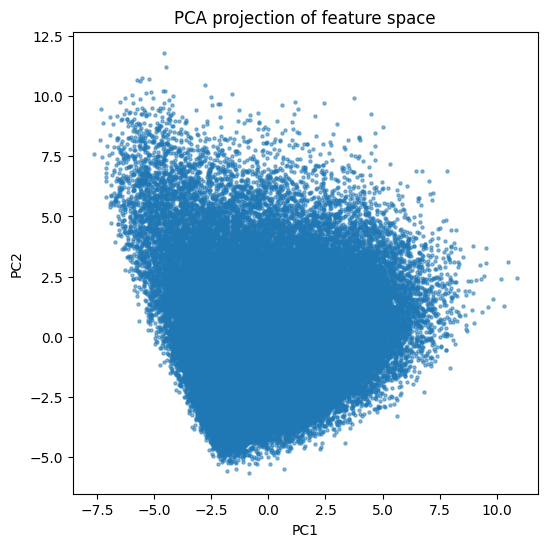

In [12]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
proj = pca.fit_transform(features.numpy())

plt.figure(figsize=(6,6))
plt.scatter(proj[:,0], proj[:,1], s=5, alpha=0.5)
plt.title("PCA projection of feature space")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()
